In [1]:
import psycopg2
import pandas as pd 
# from sqlalchemy.types import Integer, Text, String, DateTime
import sqlalchemy as s
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = s.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [2]:
repo_list = pd.DataFrame()
repo_list_query = f"""
SELECT repo_id, repo_name, repo_path from repo
WHERE repo_name = 'concourse' OR repo_name = 'postfacto' or repo_name = 'clarity' or repo_name = 'gpdb' or
      repo_name = 'kpack' or repo_name = 'rabbitmq-server' or repo_name = 'sonobuoy' or repo_name = 'contour' or
      repo_name = 'oraclelinux-extras-base' or repo_name = 'tern';
    """
repo_list = pd.read_sql_query(repo_list_query, con=engine)
print(repo_list)

    repo_id                repo_name                              repo_path
0     26983                postfacto                    github.com/pivotal/
1     26235                concourse               github.com/pcfdev-forks/
2     25432          rabbitmq-server                   github.com/rabbitmq/
3     25857                     gpdb               github.com/greenplum-db/
4     30000                  contour             github.com/projectcontour/
5     28030                 sonobuoy               github.com/vmware-tanzu/
6     26600                     gpdb  github.com/Pivotal-Field-Engineering/
7     27169                     gpdb                github.com/pivotal-gss/
8     28051                concourse                  github.com/concourse/
9     27043                    kpack                    github.com/pivotal/
10    27913                  clarity                     github.com/vmware/
11    27940                     tern                 github.com/tern-tools/
12    30160 

In [74]:
## List of repository IDs for the report
#repo_dict = {25760, 25663} #spring-boot & spring-framework
repo_dict = {28051} # concourse
#repo_dict = {26983} #postfacto
#repo_dict = {25432} #rabbitmq-server
#repo_dict = {25663} #spring-framework
#repo_dict = {25760} #sprint-boot
#repo_dict = {28030} #sonobuoy
#repo_dict = {28031} #velero
#repo_dict = {27913} #clarity
#repo_dict = {30000} #contour
#repo_dict = {27940} #tern

In [75]:
#from datetime import date
import datetime 

current = datetime.date.today()
today = "'" + str(current) + "'"
print(today)

first_current = current.replace(day=1)
last_month = first_current - datetime.timedelta(days=1)
end_date = "'" + str(last_month) + "'"
print(end_date)

print

start = last_month - datetime.timedelta(days=365)
year_ago = "'" + str(start) + "'"
print(year_ago)

'2020-04-28'
'2020-03-31'
'2019-04-01'


In [94]:
pr_all = pd.DataFrame()

for repo_id in repo_dict: 

    pr_query = s.sql.text(f"""
                     SELECT
                        repo.repo_id AS repo_id,
                        pull_requests.pr_src_id AS pr_src_id,
                        repo.repo_name AS repo_name,
                        pr_src_author_association,
                        repo_groups.rg_name AS repo_group,
                        pull_requests.pr_src_state,
                        pull_requests.pr_merged_at,
                        pull_requests.pr_created_at AS pr_created_at,
                        pull_requests.pr_closed_at AS pr_closed_at,
                        date_part( 'year', pr_created_at :: DATE ) AS CREATED_YEAR,
                        date_part( 'month', pr_created_at :: DATE ) AS CREATED_MONTH,
                        date_part( 'year', pr_closed_at :: DATE ) AS CLOSED_YEAR,
                        date_part( 'month', pr_closed_at :: DATE ) AS CLOSED_MONTH,
                        pr_src_meta_label,
                        pr_head_or_base,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_close,
                        ( EXTRACT ( EPOCH FROM pull_requests.pr_closed_at ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_close, 
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_first_response,
                        ( EXTRACT ( EPOCH FROM first_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_first_response, 
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 3600 AS hours_to_last_response,
                        ( EXTRACT ( EPOCH FROM last_response_time ) - EXTRACT ( EPOCH FROM pull_requests.pr_created_at ) ) / 86400 AS days_to_last_response, 
                        first_response_time,
                        last_response_time,
                        average_time_between_responses,
                        assigned_count,
                        review_requested_count,
                        labeled_count,
                        subscribed_count,
                        mentioned_count,
                        referenced_count,
                        closed_count,
                        head_ref_force_pushed_count,
                        merged_count,
                        milestoned_count,
                        unlabeled_count,
                        head_ref_deleted_count,
                        comment_count,
                        lines_added, 
                        lines_removed,
                        commit_count, 
                        file_count
                    FROM
                    repo,
                    repo_groups,
                    pull_requests LEFT OUTER JOIN ( 
                            SELECT pull_requests.pull_request_id,
                                MIN(message.msg_timestamp) AS first_response_time,
                                COUNT(DISTINCT message.msg_timestamp) AS comment_count,
                                MAX(message.msg_timestamp) AS last_response_time,
                                (MAX(message.msg_timestamp) - MIN(message.msg_timestamp)) / COUNT(DISTINCT message.msg_timestamp) AS average_time_between_responses
                            FROM repo, 
                                pull_requests left outer join pull_request_message_ref 
                                on pull_requests.pull_request_id = pull_request_message_ref.pull_request_id
                                left outer join message on pull_request_message_ref.msg_id = message.msg_id and cntrb_id not in (select cntrb_id from contributors where cntrb_login like '%[bot]')
                            WHERE repo.repo_id = {repo_id}
                            AND repo.repo_id = pull_requests.repo_id
                            GROUP BY pull_requests.pull_request_id
                    ) response_times
                    ON pull_requests.pull_request_id = response_times.pull_request_id
                    left outer join (
                            SELECT pull_requests.pull_request_id,
                                count(*) FILTER (WHERE action = 'assigned') AS assigned_count,
                                count(*) FILTER (WHERE action = 'review_requested') AS review_requested_count,
                                count(*) FILTER (WHERE action = 'labeled') AS labeled_count,
                                count(*) FILTER (WHERE action = 'unlabeled') AS unlabeled_count,
                                count(*) FILTER (WHERE action = 'subscribed') AS subscribed_count,
                                count(*) FILTER (WHERE action = 'mentioned') AS mentioned_count,
                                count(*) FILTER (WHERE action = 'referenced') AS referenced_count,
                                count(*) FILTER (WHERE action = 'closed') AS closed_count,
                                count(*) FILTER (WHERE action = 'head_ref_force_pushed') AS head_ref_force_pushed_count,
                                count(*) FILTER (WHERE action = 'head_ref_deleted') AS head_ref_deleted_count,
                                count(*) FILTER (WHERE action = 'milestoned') AS milestoned_count,
                                count(*) FILTER (WHERE action = 'merged') AS merged_count
                            from repo, pull_requests left outer join pull_request_events 
                                on pull_requests.pull_request_id = pull_request_events.pull_request_id
                            WHERE repo.repo_id = {repo_id}
                                AND repo.repo_id = pull_requests.repo_id
                            GROUP BY pull_requests.pull_request_id
                    ) event_counts on event_counts.pull_request_id = pull_requests.pull_request_id
                    LEFT OUTER JOIN (
                            SELECT pull_request_commits.pull_request_id, count(DISTINCT pr_cmt_sha) AS commit_count                                FROM pull_request_commits, pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_cmt_sha <> pull_requests.pr_merge_commit_sha
                            AND pr_cmt_sha <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                    ) all_commit_counts
                    ON pull_requests.pull_request_id = all_commit_counts.pull_request_id
                    LEFT OUTER JOIN (
                            SELECT MAX(pr_repo_meta_id), pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                            FROM pull_requests, pull_request_meta
                            WHERE pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND pr_head_or_base = 'base'
                            GROUP BY pull_request_meta.pull_request_id, pr_head_or_base, pr_src_meta_label
                    ) base_labels
                    ON base_labels.pull_request_id = pull_requests.pull_request_id
                    LEFT OUTER JOIN (
                            SELECT sum(cmt_added) AS lines_added, sum(cmt_removed) AS lines_removed, pull_request_commits.pull_request_id, count(DISTINCT cmt_filename) AS file_count
                            FROM pull_request_commits, commits, pull_requests, pull_request_meta
                            WHERE cmt_commit_hash = pr_cmt_sha
                            AND pull_requests.pull_request_id = pull_request_commits.pull_request_id
                            AND pull_requests.pull_request_id = pull_request_meta.pull_request_id
                            AND pull_requests.repo_id = {repo_id}
                            AND commits.repo_id = pull_requests.repo_id
                            AND commits.cmt_commit_hash <> pull_requests.pr_merge_commit_sha
                            AND commits.cmt_commit_hash <> pull_request_meta.pr_sha
                            GROUP BY pull_request_commits.pull_request_id
                    ) master_merged_counts 
                    ON pull_requests.pull_request_id = master_merged_counts.pull_request_id                   
                    WHERE 
                        repo.repo_group_id = repo_groups.repo_group_id 
                        AND repo.repo_id = pull_requests.repo_id 
                        AND repo.repo_id = {repo_id}
                        AND pr_created_at >= {year_ago}
                        AND pr_created_at <= {end_date}
                    ORDER BY
                       merged_count DESC
                       """)
    pr_a = pd.read_sql(pr_query, con=engine)
    if not pr_all.empty: 
        pr_all = pd.concat([pr_all, pr_a]) 
    else: 
        # first repo
        pr_all = pr_a
        
    get_repo_name_query = f"""
        SELECT repo_name from repo where repo_id = {repo_id};
           """
    get_repo_name = pd.read_sql_query(get_repo_name_query, con=engine)
    repo_name = get_repo_name.repo_name[0]

In [95]:
pr_all

,repo_id,pr_src_id,repo_name,pr_src_author_association,repo_group,pr_src_state,pr_merged_at,pr_created_at,pr_closed_at,created_year,...,head_ref_force_pushed_count,merged_count,milestoned_count,unlabeled_count,head_ref_deleted_count,comment_count,lines_added,lines_removed,commit_count,file_count
0,28051,278711695,concourse,CONTRIBUTOR,concourse,closed,2019-05-14 15:06:52,2019-05-14 14:32:54,2019-05-14 15:06:52,2019.0,...,0,1,0,0,1,0,NaN,NaN,NaN,NaN
1,28051,318030280,concourse,CONTRIBUTOR,concourse,closed,2019-09-16 20:21:26,2019-09-16 19:36:28,2019-09-16 20:21:26,2019.0,...,1,1,1,0,1,1,6.0,1.0,1.0,1.0
2,28051,318037220,concourse,CONTRIBUTOR,concourse,closed,2019-09-20 17:12:40,2019-09-16 19:56:18,2019-09-20 17:12:40,2019.0,...,0,1,1,0,1,2,2408.0,2253.0,14.0,61.0
3,28051,318041233,concourse,CONTRIBUTOR,concourse,closed,2019-09-16 21:05:55,2019-09-16 20:07:08,2019-09-16 21:05:55,2019.0,...,0,1,0,0,1,0,NaN,NaN,NaN,NaN
4,28051,318048196,concourse,CONTRIBUTOR,concourse,closed,2019-10-07 19:33:32,2019-09-16 20:25:54,2019-10-07 19:33:32,2019.0,...,3,1,1,0,1,7,4278.0,3164.0,22.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,28051,291177817,concourse,CONTRIBUTOR,concourse,closed,NaT,2019-06-24 15:09:08,2019-06-24 15:09:28,2019.0,...,0,0,0,0,0,2,NaN,NaN,NaN,NaN
752,28051,383511121,concourse,CONTRIBUTOR,concourse,closed,NaT,2020-03-04 12:01:15,2020-03-06 08:36:18,2020.0,...,0,0,0,0,1,1,NaN,NaN,3.0,NaN
753,28051,346294347,concourse,CONTRIBUTOR,concourse,closed,NaT,2019-11-27 15:19:57,2019-11-27 15:21:03,2019.0,...,0,0,0,0,0,0,NaN,NaN,2.0,NaN
754,28051,369789784,concourse,MEMBER,concourse,open,NaT,2020-01-31 22:02:21,NaT,2020.0,...,0,0,0,0,0,1,NaN,NaN,3.0,NaN


In [96]:
pr_all['first_response_time']

0                     NaT
1     2019-10-02 15:50:03
2     2019-09-19 20:08:00
3                     NaT
4     2019-09-17 14:56:06
              ...        
751   2019-06-25 13:11:49
752   2020-03-06 08:36:18
753                   NaT
754   2020-01-31 22:05:20
755   2020-02-13 16:27:08
Name: first_response_time, Length: 756, dtype: datetime64[ns]

In [100]:
from pandas.tseries.offsets import BusinessDay

bd = pd.tseries.offsets.BusinessDay(n = 2) 

pr_all['diff'] = pr_all.first_response_time - pr_all.pr_created_at
pr_all['2_bus_days'] = pr_all.pr_created_at + bd
pr_all['yearmonth'] = pr_all['pr_created_at'].dt.strftime('%Y-%m')

pr_all['in_guidelines'] = np.where(pr_all['2_bus_days'] < pr_all['first_response_time'], 0, 1)
 
year_month_list = pr_all.yearmonth.unique()
year_month_list.sort()
first_response = pr_all.groupby(['repo_name', 'yearmonth'], as_index=False).sum()[['repo_name', 'yearmonth', 'in_guidelines']]

# counts total number of PRs each month
total_by_month = pr_all.groupby(['repo_name', 'yearmonth'], as_index=False).count()[['repo_name', 'yearmonth', 'pr_created_at']]

first_response['total_prs'] = total_by_month['pr_created_at']
#first_response['in_guidelines'] = first_response['total_prs'] - first_response['outside_guidelines']
first_response['percent'] = first_response['in_guidelines'] / first_response['total_prs']
print(first_response)

#for x in pr_all.iterrows():
#    if x[1]['first_response_time'] > x[1]['2_bus_days']:
#        print(x[1]['pr_created_at'], x[1]['first_response_time'], x[1]['pr_closed_at'], x[1]['diff'], x[1]['2_bus_days'])

    repo_name yearmonth  in_guidelines  total_prs   percent
0   concourse   2019-04             55         62  0.887097
1   concourse   2019-05             43         52  0.826923
2   concourse   2019-06             33         41  0.804878
3   concourse   2019-07             34         48  0.708333
4   concourse   2019-08             38         51  0.745098
5   concourse   2019-09             82         97  0.845361
6   concourse   2019-10             73         90  0.811111
7   concourse   2019-11             78         86  0.906977
8   concourse   2019-12             48         54  0.888889
9   concourse   2020-01             51         56  0.910714
10  concourse   2020-02             51         60  0.850000
11  concourse   2020-03             51         59  0.864407


'plottermonthlabels = ax.set_xticklabels(pr_sustainDF[\'yearmonth\'])\nplottermonthlabels = ax.set_ylabel(\'Number of PRs\')\nplottermonthlabels = ax.set_xlabel(\'Year Month\n\nInterpretation: Healthy projects will have little or no gap. A large or increasing gap requires attention.\')\n\ntoday = datetime.date.today()\ncurrent_year_month = str(today.year) + \'-\' + \'{:02d}\'.format(today.month)\n\nfilename = \'output/sustains_pr_\' + repo_name + "_" + current_year_month + \'.png\'\n\nfig.savefig(filename, bbox_inches=\'tight\')'

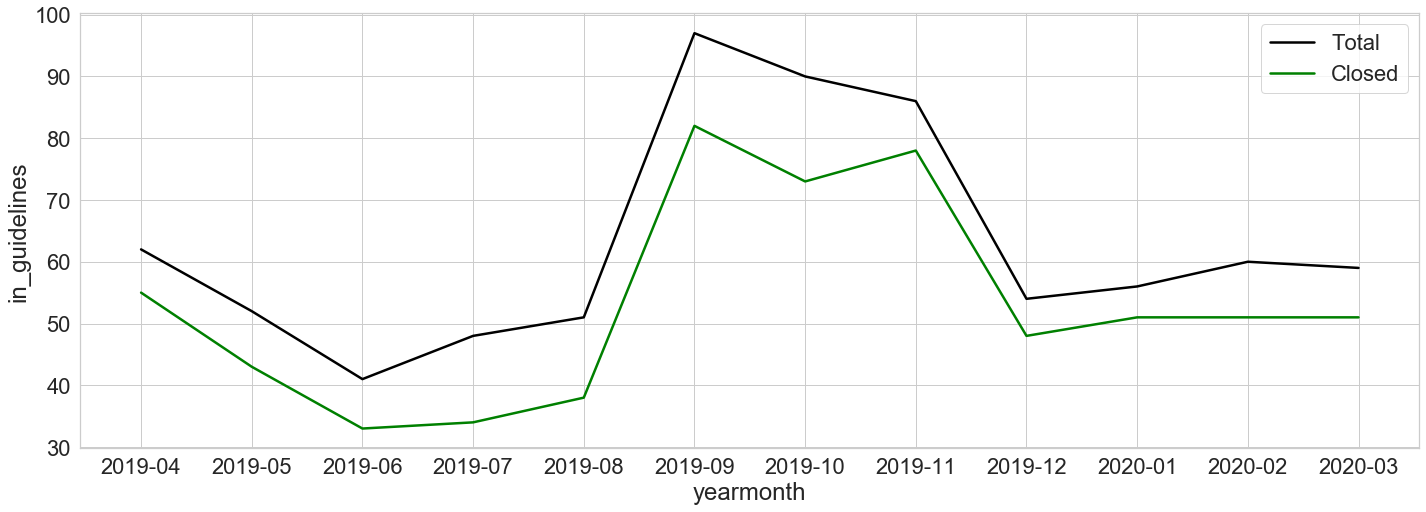

In [101]:
#pr_sustainDF['repo_id'] = pr_sustainDF['repo_id'].map(int)
#pr_sustainDF['yearmonth'] = pr_sustainDF['yearmonth'].map(str)
#pr_sustainDF.set_index('repo_id', 'yearmonth')

sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()

# the size of A4 paper
fig.set_size_inches(24, 8)

'''
risk_num = 0
h = 1
for diff_per in pr_sustainDF['diff_per']:
    if (diff_per > 0.10 and h >=6):
        risk_num+=1
    h+=1
print(risk_num)

title = pr_sustainDF['repo_name'][0] + "\nSustains and Keeps up with Contributions Metric:"

if risk_num >= 1:
    title += " AT RISK\n" + str(risk_num) + " month(s) with > 10% of total pull requests not closed"
    title_color = 'firebrick'
else:
    title += " Healthy\nMore than 90% of total pull requests are closed each month."
    title_color = 'forestgreen'
'''

plottermonth = sns.lineplot(x='yearmonth', y='total_prs', data=first_response, sort=False, color='black', label='Total', linewidth=2.5)
plottermonth = sns.lineplot(x='yearmonth', y='in_guidelines', data=first_response, sort=False, color='green', label='Closed', linewidth=2.5, linestyle='dashed')#.set_title(title, fontsize=30, color=title_color) 

'''plottermonthlabels = ax.set_xticklabels(pr_sustainDF['yearmonth'])
plottermonthlabels = ax.set_ylabel('Number of PRs')
plottermonthlabels = ax.set_xlabel('Year Month\n\nInterpretation: Healthy projects will have little or no gap. A large or increasing gap requires attention.')

today = datetime.date.today()
current_year_month = str(today.year) + '-' + '{:02d}'.format(today.month)

filename = 'output/sustains_pr_' + repo_name + "_" + current_year_month + '.png'

fig.savefig(filename, bbox_inches='tight')'''

In [10]:
    bar_colors = []
    k = 1
    risk_num = 0
    for med in first_response_median.diff_days:
        if med > 1:
            bar_colors.append('red')
            if k >= 6:
                risk_num+=1
        else:
            bar_colors.append('lightblue')
        k+=1
    print(risk_num, bar_colors)

0 ['lightblue', 'lightblue', 'lightblue', 'red', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue']


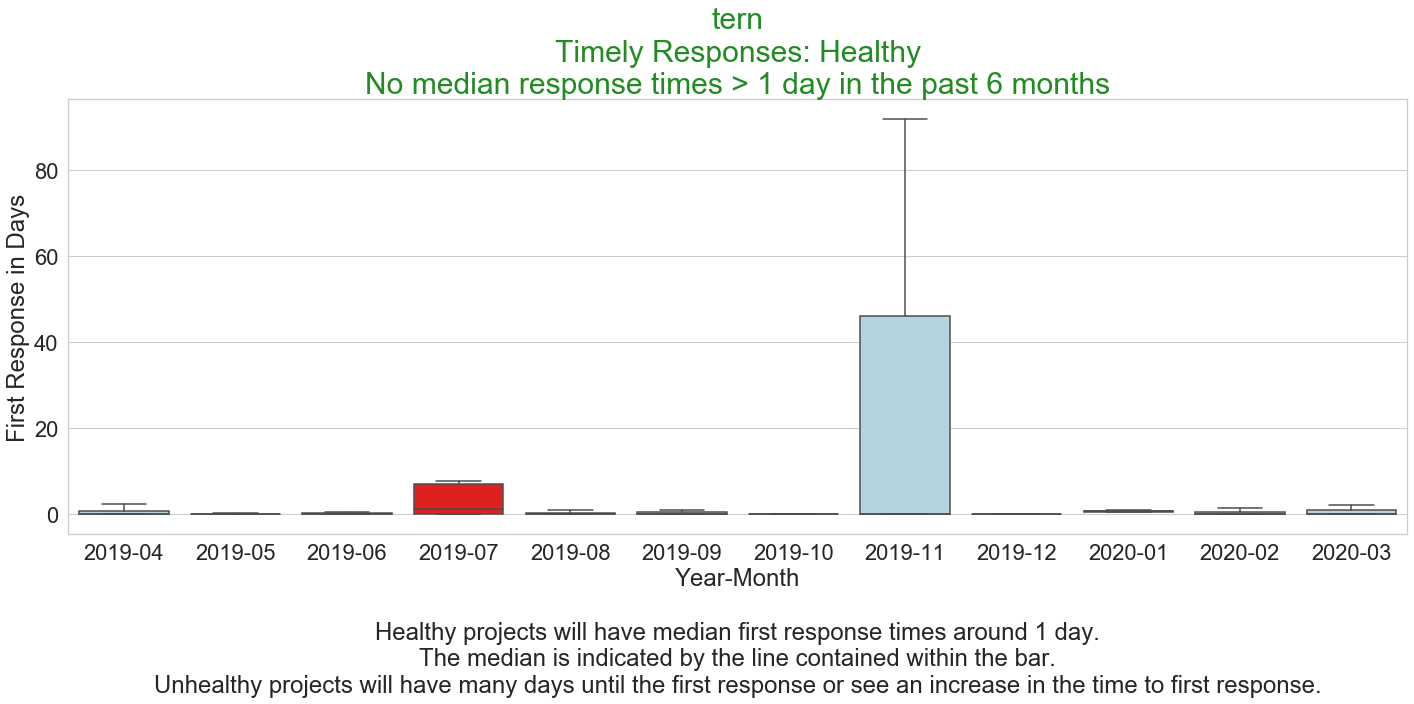

In [11]:
sns.set_style('ticks')
sns.set(style="whitegrid", font_scale=2)

fig, ax = plt.subplots()
fig.set_size_inches(24, 8)

title = repo_name + "\nTimely Responses:"

if risk_num >= 1:
    title += " AT RISK\n" + str(risk_num) + " month(s) with median response times > 1 day in the past 6 months"
    title_color = 'firebrick'
else:
    title += " Healthy\nNo median response times > 1 day in the past 6 months"
    title_color = 'forestgreen'

my_plot = sns.boxplot(x='yearmonth', y='diff_days', palette=bar_colors, data=pr_all, ax=ax, order=year_month_list, showfliers = False, whis=3).set_title(title, fontsize=30, color=title_color)

risk_bar_labels = ax.set_ylabel('First Response in Days')
risk_bar_labels = ax.set_xlabel('Year-Month\n\nHealthy projects will have median first response times around 1 day.\nThe median is indicated by the line contained within the bar.\nUnhealthy projects will have many days until the first response or see an increase in the time to first response.')